**Adverse Event Detection**

This notebook illustrates how adverse events related to medical products can be detected based on short texts, which potentially contain an adverse event. The task is to classify if a short text is containing an adverse event or not. The notebook is designed to run on Google Colab

We start to install all relevant dependencies:

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

In [3]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip install torch

In [ ]:
!pip install datasets

You should have the file `ae_summer_school.json` located on your local machine, cf. the instructions in the README of the corresponding repository







To make this file available in the colab environment, execute


```
from google.colab import files
uploaded = files.upload()
```
and select the path to the file on your local machine


In [ ]:
from google.colab import files
uploaded = files.upload()

Let us write a helper function to load data from a json file and store it in a pandas dataframe

In [ ]:
import pandas as pd
def get_data(json_file_name):
  df=pd.read_json(json_file_name)
  return df


Now we can load the data containing adverse events

In [ ]:
df = get_data('ae_summer_school.json')

Let us explore the dataset briefly and check if classes are imbalanced

In [ ]:
df.head()

,sentence,adverse_event
0,The patient experienced severe abdominal pain ...,Yes
1,The laboratory test results showed no abnormal...,No
2,"The medication was well-tolerated, with no rep...",No
3,The participant developed a rash and itching a...,Yes
4,The patient suffered from dizziness and nausea...,Yes


In [ ]:
df.groupby('adverse_event').size()

adverse_event
No     236
Yes    216
dtype: int64

We want to replace the Yes/No values by 1/0 and rename the columns and write a function which is doing this

In [ ]:
def preprocessing(df):
  df['label'] = df['adverse_event'].replace({'Yes':1, 'No':0})
  df = df.rename(columns={'sentence': 'label_text'})
  return df

In [ ]:
df = preprocessing(df)

In [ ]:
df.head()

,label_text,adverse_event,label
0,The patient experienced severe abdominal pain ...,Yes,1
1,The laboratory test results showed no abnormal...,No,0
2,"The medication was well-tolerated, with no rep...",No,0
3,The participant developed a rash and itching a...,Yes,1
4,The patient suffered from dizziness and nausea...,Yes,1


**Training of a model to detect adverse events**

We start to split the data into a train/val/test set

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def train_test_val_split(df):
  # Split the DataFrame into train and remaining data
  df_train, df_remaining = train_test_split(df, test_size=0.3, random_state=42)

  # Split the remaining data into test and validation sets
  df_test, df_val = train_test_split(df_remaining, test_size=0.5, random_state=42)

  # Print the shapes of the resulting DataFrames
  print("Train set shape:", df_train.shape)
  print("Test set shape:", df_test.shape)
  print("Validation set shape:", df_val.shape)
  return df_train, df_val, df_test


In [ ]:
df_train, df_val, df_test = train_test_val_split(df)

Train set shape: (316, 3)
Test set shape: (68, 3)
Validation set shape: (68, 3)


We want to utilize pre-trained model which incorporate knowledge from the medical domain. This allows us to work with ‘small data’

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer
import torch
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score

# Load pre-trained model and tokenizer
model_name = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

We don't need to create our own model architecture. Instead, we use the Huggingface

```
Trainer
```
class, which provides an abstraction for the training process. It requires to transform the training data into the Huggingface


```
Dataset
```
type



In [ ]:
def get_dataset_encodings(df, sentence_key='label_text'):
  # convert to Dataset type
  dataset_ = Dataset.from_pandas(df)

  def encode_records(record, tokenizer=tokenizer, sentence_key=sentence_key):
    return tokenizer(record[sentence_key], truncation=True, padding=True)

  # Tokenize and encode data
  dataset_encodings = dataset_.map(encode_records, batched=True)
  return dataset_encodings



In [ ]:
dataset_train_encodings = get_dataset_encodings(df_train)
dataset_val_encodings = get_dataset_encodings(df_val)
dataset_test_encodings = get_dataset_encodings(df_test)

Map:   0%|          | 0/316 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

In [ ]:
dataset_train_encodings

Dataset({
    features: ['label_text', 'adverse_event', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 316
})

Now we can define hyperparameters which we want to use during training using the Huggingface

```
TrainingArguments
```
Class


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',  # Directory to save the model checkpoints
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',  # Directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

We will use accuracy as metric (since we have no class imbalance)

In [ ]:
def compute_accuracy(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels,preds)
    return {'accuracy': accuracy}

Now we are able to create an object of the


```
Trainer
```
Class using the pre-trained model, the hyperparameters and our training and validation data


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics = compute_accuracy,
    train_dataset=dataset_train_encodings,
    eval_dataset=dataset_val_encodings
)

Let's start the training

In [ ]:
# Fine-tune the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.512500,0.441413,0.941176
2,0.092600,0.079328,0.985294
3,0.054300,0.080045,0.985294


TrainOutput(global_step=120, training_loss=0.3086552157998085, metrics={'train_runtime': 343.7255, 'train_samples_per_second': 2.758, 'train_steps_per_second': 0.349, 'total_flos': 12666330649440.0, 'train_loss': 0.3086552157998085, 'epoch': 3.0})

In [ ]:
def get_predictions(lst_medical_observations, trainer=trainer):
  df = pd.DataFrame({'label_text': lst_medical_observations})
  encodings = get_dataset_encodings(df)
  predictions = trainer.predict(encodings)
  probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
  return probabilities


Let's check a few examples

In [ ]:
get_predictions(['I took an aspirin and got a headache'])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

tensor([[0.1944, 0.8056]])

In [ ]:
get_predictions(['The patiend was fine'])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

tensor([[0.7075, 0.2925]])

The examples look ok, let us now check the accuracy on the test set

In [ ]:
trainer.evaluate(dataset_test_encodings)

{'eval_loss': 0.06787075102329254,
 'eval_accuracy': 0.9852941176470589,
 'eval_runtime': 5.7558,
 'eval_samples_per_second': 11.814,
 'eval_steps_per_second': 1.564,
 'epoch': 3.0}

It seems that our model is performing well and we want to offer it 'as a service' for detecting adverse event. Therefore, we use it on potential adverse events from another data source. The new data should be stored on your local machine with the file name


```
ae_summer_school_new.json
```



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ae_summer_school_new.json to ae_summer_school_new.json


In [ ]:
df_new = get_data('ae_summer_school_new.json')

In [ ]:
df_new.head()

,sentence,adverse_event
0,"Just tried this new treatment, feeling like a ...",No
1,"Ugh, these meds are not my cup of tea. Can't w...",Yes
2,"No issues with the therapy, feeling energized ...",No
3,"This drug is messing with my vibe, everything ...",Yes
4,Feeling on top of the world after the treatmen...,No


The data has the same format as before and looks quite similar. Let's do the preprocessing and make predictions and evaluate the performance. Note: in a real worl scenario the ground-truth label would not be available

In [ ]:
df_new_preprocessed = preprocessing(df_new)

In [ ]:
df_new_encoded = get_dataset_encodings(df_new_preprocessed)

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

We can use the evaluate method of the train object to compute the accuracy of the predictions for the new data
```



In [ ]:
trainer.evaluate(df_new_encoded)

{'eval_loss': 0.39869922399520874,
 'eval_accuracy': 0.8,
 'eval_runtime': 2.0344,
 'eval_samples_per_second': 9.831,
 'eval_steps_per_second': 1.475,
 'epoch': 3.0}

The accuracy dropped from 99% to 80%, that's a lot. Why did this happen? Let us analyse the texts a bit using words clouds and comparing the distribution of words

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from scipy.stats import entropy
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

def get_word_clouds_and_entropy(corpus1, corpus2):


  # Combine corpus 1 and corpus 2
  combined_corpus = corpus1 + corpus2

  # Tokenize the combined corpus
  tokens = [word_tokenize(sentence) for sentence in combined_corpus]

  # Compute word frequencies for combined corpus
  word_freqs = FreqDist([word for sentence in tokens for word in sentence])
  total_words = sum(word_freqs.values())

  # Compute word probabilities for combined corpus
  word_probs = {word: freq / total_words for word, freq in word_freqs.items()}

  # Compute word frequencies for corpus 1
  corpus1_word_freqs = FreqDist([word for sentence in corpus1 for word in word_tokenize(sentence)])

  # Compute word probabilities for corpus 1
  corpus1_word_probs = {word: freq / len(corpus1) for word, freq in corpus1_word_freqs.items()}

  # Compute word frequencies for corpus 2
  corpus2_word_freqs = FreqDist([word for sentence in corpus2 for word in word_tokenize(sentence)])

  # Compute word probabilities for corpus 2
  corpus2_word_probs = {word: freq / len(corpus2) for word, freq in corpus2_word_freqs.items()}

  # Find common vocabulary
  common_vocab = set(corpus1_word_probs.keys()).intersection(corpus2_word_probs.keys())

  # Compute relative entropy (Kullback-Leibler divergence) for common vocabulary
  relative_entropy = entropy([corpus1_word_probs[word] for word in common_vocab], [corpus2_word_probs[word] for word in common_vocab])
  print("Relative Entropy:", relative_entropy)

  # Plot word cloud for corpus 1
  corpus1_word_cloud = WordCloud().generate_from_frequencies(corpus1_word_probs)
  plt.imshow(corpus1_word_cloud, interpolation="bilinear")
  plt.title("Word Cloud - Corpus 1")
  plt.axis("off")
  plt.show()

  # Plot word cloud for corpus 2
  corpus2_word_cloud = WordCloud().generate_from_frequencies(corpus2_word_probs)
  plt.imshow(corpus2_word_cloud, interpolation="bilinear")
  plt.title("Word Cloud - Corpus 2")
  plt.axis("off")
  plt.show()

  return relative_entropy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
corpus_training = list(df_train['label_text'])
corpus_test = list(df_test['label_text'])
corpus_val = list(df_val['label_text'])
corpus_new = list(df_new_preprocessed['label_text'])

Relative Entropy: 0.06124188306378763


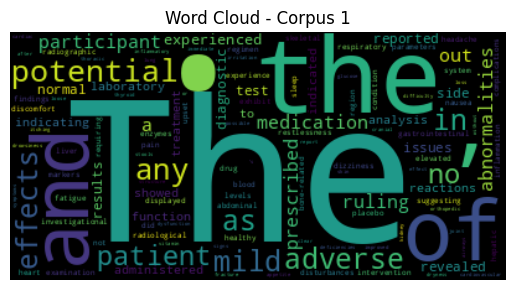

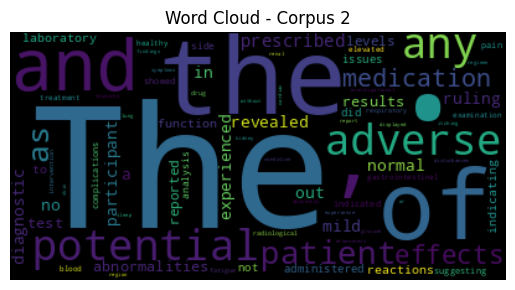

In [ ]:
rel_entropy_train_test=get_word_clouds_and_entropy(corpus_training, corpus_test)

The word clouds looks comparable and the relative entropy is very low. That indicates that we have tested the model on a dataset which is comming from the same distribution as the training data

Relative Entropy: 0.47577936954706124


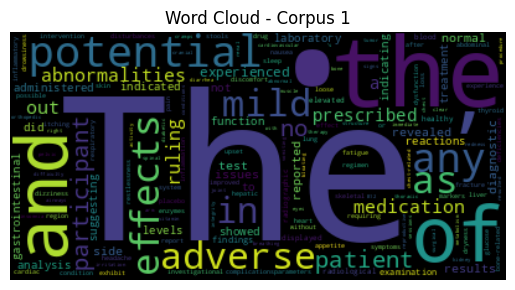

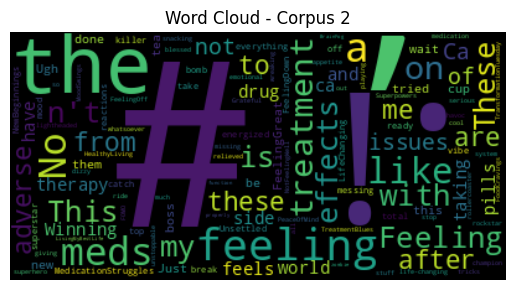

In [ ]:
rel_entropy_train_new=get_word_clouds_and_entropy(corpus_training, corpus_new)

We see # and ! in the word cloud. That's something we would not expect to see in medical notes written by a healthcare professional. Also, the entropy is much higher which indicates that the new data is comming from a different probability distribution. Maybe tweets?

Relative Entropy: 0.09310786116359285


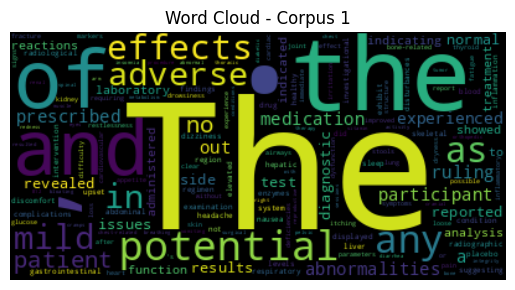

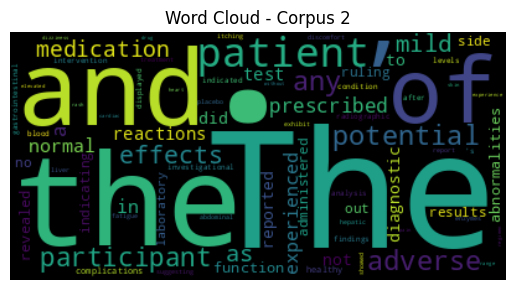

In [ ]:
rel_entropy_train_val=get_word_clouds_and_entropy(corpus_training, corpus_val)

Relative Entropy: 0.06142127179213025


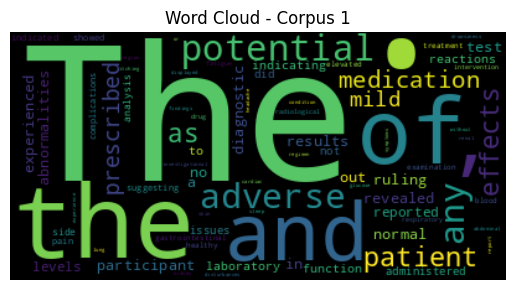

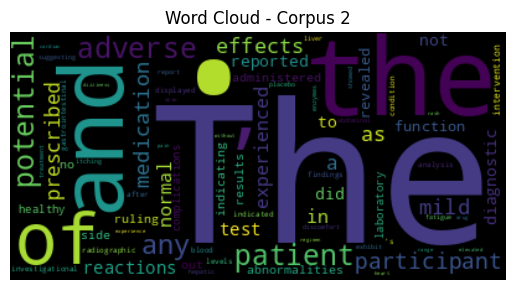

In [ ]:
rel_entropy_test_val=get_word_clouds_and_entropy(corpus_test, corpus_val)

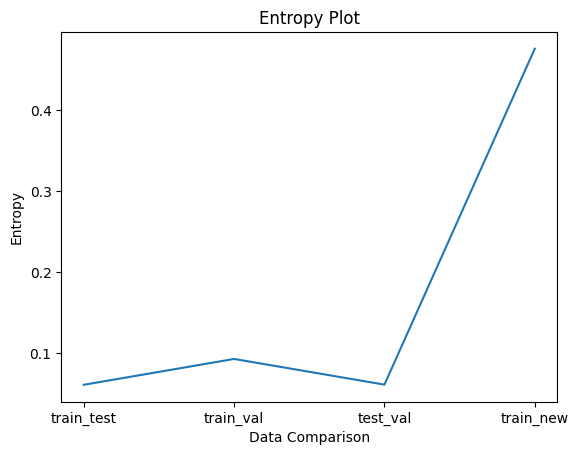

In [ ]:
import matplotlib.pyplot as plt

def plot_entropy(data_comparison, entropy):
    plt.plot(data_comparison, entropy)
    plt.xlabel('Data Comparison')
    plt.ylabel('Entropy')
    plt.title('Entropy Plot')

    # Set custom x-axis tick labels
    plt.xticks(range(len(data_comparison)), data_comparison)

    plt.show()

# Example usage
data_comparison = ['train_test', 'train_val', 'test_val','train_new']
entropy = [rel_entropy_train_test, rel_entropy_train_val, rel_entropy_test_val, rel_entropy_train_new]

plot_entropy(data_comparison, entropy)


Alternative: detecting drift using a binary classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def train_classifier(corpus, new_data):
    # Combine corpus and new data
    data = corpus + new_data

    # Assign labels (0 for corpus, 1 for new data)
    labels = [0] * len(corpus) + [1] * len(new_data)

    # Vectorize the text data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(data)

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    # Train a binary classifier
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test set
    accuracy = classifier.score(X_test, y_test)
    print("Classifier Accuracy:", accuracy)

    return classifier, vectorizer






In [ ]:
corpus = corpus_training
new_data = corpus_new

# Train the classifier on the corpus and new data
classifier, vectorizer = train_classifier(corpus, new_data)

Classifier Accuracy: 1.0
